In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
truth_vtx_z = np.array([], dtype='object')
truth_vtx_z_HS = np.array([], dtype='object')

reco_vtx_z = np.array([], dtype='object')
reco_vtx_z_HS = np.array([], dtype='object')
reco_vtx_sum_pt2 = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            event_truth_vtx_z = tree['truthvertex_z'].array(library='np')
            event_reco_vtx_z = tree['recovertex_z'].array(library='np')
            
            truth_vtx_z = np.concatenate((truth_vtx_z, event_truth_vtx_z))
            reco_vtx_z = np.concatenate((reco_vtx_z, event_reco_vtx_z))
            
            reco_vtx_sum_pt2 = np.concatenate((reco_vtx_sum_pt2, tree['recovertex_sumPt2'].array(library='np')))
            
            truth_vtx_z_HS = np.concatenate((truth_vtx_z_HS, event_truth_vtx_z[0]))
            reco_vtx_z_HS = np.concatenate((reco_vtx_z_HS, event_reco_vtx_z[0]))

In [3]:
delta_z_max = 10 # plot all within 1 cm

#Only look at truth HS
#For different root(sum pT square) limits
delta_zs_5 = np.array([])
delta_zs_10 = np.array([])
delta_zs_15 = np.array([])
for tr_zs, re_zs, re_sum_pt2 in zip(truth_vtx_z, reco_vtx_z, reco_vtx_sum_pt2):
    ## Loop over all reco
    idxs5 = re_sum_pt2 > 5**2
    idxs10 = re_sum_pt2 > 10**2
    idxs15 = re_sum_pt2 > 15**2
    # print(np.sum(idxs5), np.sum(idxs10), np.sum(idxs15))
        
    diff_vec5  = re_zs[idxs5] - tr_zs[0]
    diff_vec10 = re_zs[idxs10] - tr_zs[0]
    diff_vec15 = re_zs[idxs15] - tr_zs[0]
    
    diff_idx5  = np.abs(diff_vec5) < delta_z_max
    diff_idx10 = np.abs(diff_vec10) < delta_z_max
    diff_idx15 = np.abs(diff_vec15) < delta_z_max
    
    delta_zs_5  = np.concatenate((delta_zs_5,   diff_vec5[diff_idx5]))
    delta_zs_10 = np.concatenate((delta_zs_10, diff_vec10[diff_idx10]))
    delta_zs_15 = np.concatenate((delta_zs_15, diff_vec15[diff_idx15]))

findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


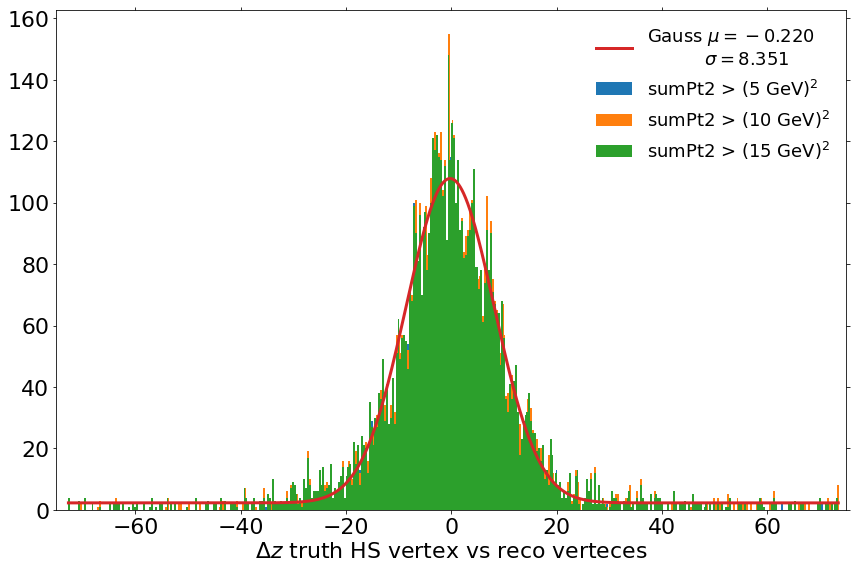

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

dz_plot_max = 75

plot_idx5 =  1e3*np.abs(delta_zs_5)  < dz_plot_max
plot_idx10 = 1e3*np.abs(delta_zs_10) < dz_plot_max
plot_idx15 = 1e3*np.abs(delta_zs_15) < dz_plot_max

bin_heights5, bin_borders5, _   = ax.hist(1e3*delta_zs_5 [plot_idx5],  bins = 400, label='sumPt2 > (5 GeV)$^2$')
bin_heights10, bin_borders10, _ = ax.hist(1e3*delta_zs_10[plot_idx10], bins = 400, label='sumPt2 > (10 GeV)$^2$')
bin_heights15, bin_borders15, _ = ax.hist(1e3*delta_zs_15[plot_idx15], bins = 400, label='sumPt2 > (15 GeV)$^2$')

bin_centers15 = bin_borders15[:-1] + np.diff(bin_borders15) / 2
popt1, _ = curve_fit(gaussian, bin_centers15, bin_heights15, p0=[2500., 0., 10, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders15[0], bin_borders15[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt1), lw=3, label='Gauss $\\mu={:.3f}$\n          $\\sigma={:.3f}$'.format(popt1[1], popt1[2]))


ax.legend(frameon=False)
ax.set_xlim(-dz_plot_max, dz_plot_max)
ax.set_xlabel('$\\Delta z$ truth HS vertex vs reco verteces')

fig.tight_layout()

In [6]:
## Alternative analysis
## Look at reco vtx with sumpT2 above some threshold and compare dz with all truth vtxs

delta_z_max = 2 # plot all within 0.2 cm

alt_delta_zs_5 = np.array([])
alt_delta_zs_10 = np.array([])
alt_delta_zs_15 = np.array([])
for tr_zs, re_zs, re_sum_pt2 in zip(truth_vtx_z, reco_vtx_z, reco_vtx_sum_pt2):
    idxs5 = re_sum_pt2 > 5**2
    idxs10 = re_sum_pt2 > 10**2
    idxs15 = re_sum_pt2 > 15**2
    
    xv5, yv5 = np.meshgrid(tr_zs, re_zs[idxs5])
    all_delta_z5 = flatten_array(xv5-yv5)
    xv10, yv10 = np.meshgrid(tr_zs, re_zs[idxs10])
    all_delta_z10 = flatten_array(xv10-yv10)
    xv15, yv15 = np.meshgrid(tr_zs, re_zs[idxs15])
    all_delta_z15 = flatten_array(xv15-yv15)
    
    diff_idx5  = np.abs(all_delta_z5)  < delta_z_max
    diff_idx10 = np.abs(all_delta_z10) < delta_z_max
    diff_idx15 = np.abs(all_delta_z15) < delta_z_max
    
    alt_delta_zs_5  = np.concatenate((alt_delta_zs_5,  all_delta_z5[diff_idx5]))
    alt_delta_zs_10 = np.concatenate((alt_delta_zs_10, all_delta_z10[diff_idx10]))
    alt_delta_zs_15 = np.concatenate((alt_delta_zs_15, all_delta_z15[diff_idx15]))

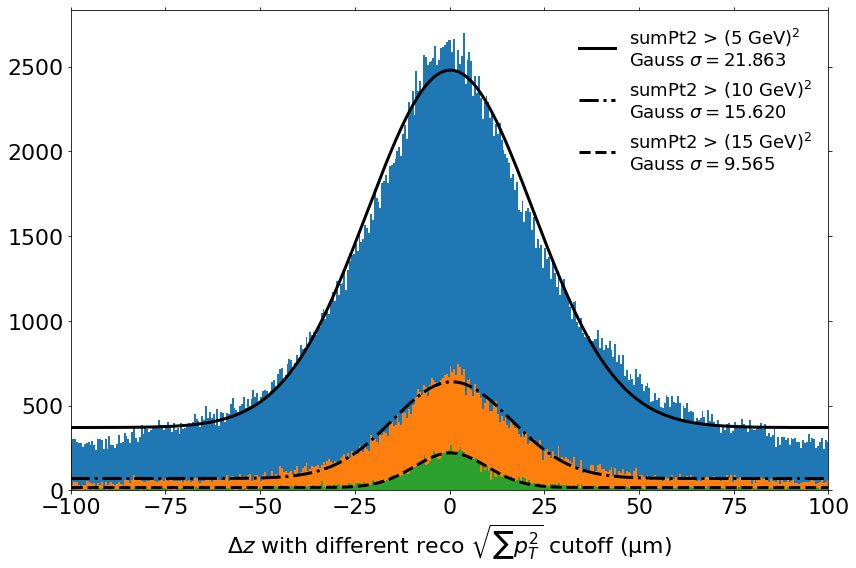

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

dz_plot_max = 100

plot_idx5 =  1e3*np.abs(alt_delta_zs_5)  < dz_plot_max
plot_idx10 = 1e3*np.abs(alt_delta_zs_10) < dz_plot_max
plot_idx15 = 1e3*np.abs(alt_delta_zs_15) < dz_plot_max

bin_heights5, bin_borders5, _   = ax.hist(1e3*alt_delta_zs_5 [plot_idx5],  bins = 400)#, label='sumPt2 > (5 GeV)$^2$')
bin_heights10, bin_borders10, _ = ax.hist(1e3*alt_delta_zs_10[plot_idx10], bins = 400)#, label='sumPt2 > (10 GeV)$^2$')
bin_heights15, bin_borders15, _ = ax.hist(1e3*alt_delta_zs_15[plot_idx15], bins = 400)#, label='sumPt2 > (15 GeV)$^2$')

bin_centers5 = bin_borders5[:-1] + np.diff(bin_borders5) / 2
bin_centers10 = bin_borders10[:-1] + np.diff(bin_borders10) / 2
bin_centers15 = bin_borders15[:-1] + np.diff(bin_borders15) / 2
popt5, _  = curve_fit(gaussian, bin_centers5,  bin_heights5,  p0=[2500., 0., 10, 0])
popt10, _ = curve_fit(gaussian, bin_centers10, bin_heights10, p0=[2500., 0., 10, 0])
popt15, _ = curve_fit(gaussian, bin_centers15, bin_heights15, p0=[2500., 0., 10, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders5[0], bin_borders5[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt5), 'k-', lw=3, label='sumPt2 > (5 GeV)$^2$\nGauss $\\sigma={:.3f}$'.format(popt5[2]), zorder=10)

x_interval_for_fit = np.linspace(bin_borders10[0], bin_borders10[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt10), 'k-.', lw=3, label='sumPt2 > (10 GeV)$^2$\nGauss $\\sigma={:.3f}$'.format(popt10[2]), zorder=10)

x_interval_for_fit = np.linspace(bin_borders15[0], bin_borders15[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt15), 'k--', lw=3, label='sumPt2 > (15 GeV)$^2$\nGauss $\\sigma={:.3f}$'.format(popt15[2]), zorder=10)

ax.legend(frameon=False)
ax.set_xlim(-dz_plot_max, dz_plot_max)
ax.set_xlabel('$\\Delta z$ with different reco $\\sqrt{\\sum p_T^2}$ cutoff (µm)')

fig.tight_layout()

In [26]:
# For each event compare all V_truth and V_reco z-positions
delta_zs_min = []
for tr_zs, re_zs in zip(truth_vtx_z, reco_vtx_z):
    xv, yv = np.meshgrid(tr_zs, re_zs)
    diff_matrix = xv-yv
    for r in diff_matrix:
        idx = np.argmin(np.abs(r))
        delta_zs_min.append(r[idx])
delta_zs_min = np.array(delta_zs_min)

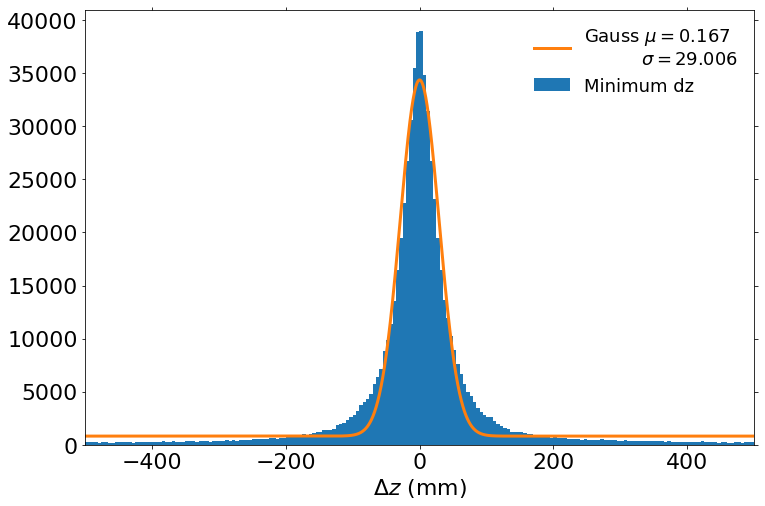

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

z_lim = 500

bin_heights, bin_borders, _ = ax.hist(1e3*delta_zs_min[np.abs(1e3*delta_zs_min) < z_lim], 200, label='Minimum dz')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[10000., 0., 30, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), lw=3, label='Gauss $\\mu={:.3f}$\n          $\\sigma={:.3f}$'.format(popt[1], popt[2]))


ax.set_xlim(-z_lim, z_lim)
ax.set_xlabel('$\\Delta z$ (mm)')
ax.legend(frameon=False)